<a href="https://colab.research.google.com/github/MakhovaAnastasia/Paper_Fuzzy_LSTM/blob/main/LSTM_param%2B_FuzzyLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***LSTM с параметрической сигмоидой для прогнозирования цен.***

Импортируем нужные библиотеки

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout, Layer, RNN
from keras.layers import LSTM, Input
from keras.models import Sequential
from tensorflow.keras.layers import LSTMCell
import tensorflow.keras.backend as K
from keras.initializers import Constant
from keras.utils import get_custom_objects

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,mean_absolute_percentage_error

import math
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date,timedelta
import time

from prettytable import PrettyTable
import matplotlib.pyplot as plt
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib inline

Собираем данные на разных тенорах

In [ ]:
def get_historical_close_data(name,step):
  if step=='1d':
    start = '2018-01-01'
    end = '2024-02-15'
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1d')
    data.reset_index(inplace=True)
    data = data.loc[:,('Date','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1h':
    start = '2023-01-01'
    end = '2024-02-15'
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1h')
    data.reset_index(inplace=True)
    data = data.loc[:,('Datetime','Close')]
    data = data.sort_index(ascending = False)
    return data
  if step=='1m':
    start = date.today()-timedelta(days=7)
    end = date.today()
    data = yf.Ticker(name)
    data=data.history(start=start, end=end,interval ='1m')
    data.reset_index(inplace=True)
    return data

Нормализация данных и денормализация

In [ ]:
def normalization(data):
    scaler = MinMaxScaler(feature_range = (0,1))
    data_norm = scaler.fit_transform(data)

    return data_norm

In [ ]:
def de_normalization(data, new_data):
    scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit_transform(data)
    unormalized = scaler.inverse_transform(new_data)

    return unormalized

Разбиваем данные на тренировочную и тестовую выборку и преобразуем их в нужный для LSTM формат

In [ ]:
def split_train_test(data):

    # split into train and test sets
    train_size = int(len(data) * 0.75)
    train, test = data[0:train_size,], data[train_size:len(data),]
    return train, test

def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookback-1):
      a = dataset[i:(i+lookback), 0]
      dataX.append(a)
      dataY.append(dataset[i + lookback, 0])
    return np.array(dataX), np.array(dataY)

Так как в LSTM базовая функция активации -- tanh, по результатам прошлых лет выбираем следующие параметры:

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30

Подготавливаем данные: скачиваем, нормализуем, формируем выборки

In [ ]:
dataset = get_historical_close_data(companies,step)
scaler=MinMaxScaler(feature_range=(0,1))
dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))
train_dataset, test_dataset = split_train_test(dataset_norm)
train_X, train_y = create_dataset(train_dataset, lookback)
test_X, test_y = create_dataset(test_dataset,lookback)


train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)


LSTM с параметрическими сигмоидами.

In [ ]:
class ParametricLSTMCell_3sigma(LSTMCell):
    def build(self, input_shape):
        super().build(input_shape)
        # Добавляем параметры активации (α и β для сигмоиды)
        self.alpha = self.add_weight(
            name='alpha',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta = self.add_weight(
            name='beta',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )
        self.alpha2 = self.add_weight(
            name='alpha2',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta2 = self.add_weight(
            name='beta2',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )
        self.alpha3 = self.add_weight(
            name='alpha3',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta3 = self.add_weight(
            name='beta3',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )

    def param_sigmoid(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha * (x - self.beta)))

    def param_sigmoid2(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha2 * (x - self.beta2)))

    def param_sigmoid3(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha3 * (x - self.beta3)))

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # предыдущий скрытый
        c_tm1 = states[1]  # предыдущий cell state

        z = K.dot(inputs, self.kernel)
        z += K.dot(h_tm1, self.recurrent_kernel)
        if self.use_bias:
            z = K.bias_add(z, self.bias)

        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

        # Используем нашу сигмоиду
        i = self.param_sigmoid(z0)     # input gate
        f = self.param_sigmoid2(z1)     # forget gate
        c = f * c_tm1 + i * K.tanh(z2) # cell state
        o = self.param_sigmoid3(z3)     # output gate

        h = o * K.tanh(c)
        return h, [h, c]

Запускаем обучение LSTM с функцией потерь MSE и алгоритмом оптимизации ADAM

In [ ]:
model = Sequential()
model.add(Input(shape=(lookback, 1)))
model.add(RNN(ParametricLSTMCell_3sigma(unit)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
start_time = time.time()
result=model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=False)
end_time = time.time()
train_timing=(end_time-start_time)

In [ ]:
print(f"time = {train_timing}")

time = 431.5965690612793


Делаем прогноз на тренировочной и тестовой выборке

In [ ]:
train_predict=model.predict(train_X)
start_time = time.time()
test_predict=model.predict(test_X)
end_time = time.time()
test_timing=(end_time-start_time)
#train_predict.shape, test_predict.shape
print(f"time = {test_timing}")

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
time = 0.6807811260223389


Возвращаем данные в исходные единицы измерения

In [ ]:

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1))
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

График с оригинальными данными и прогнозами:

In [ ]:
trainPredictPlot = np.empty_like(dataset_norm)
trainPredictPlot[:, ] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, ] = train_predict[:,0].reshape(-1,1)
testPredictPlot = np.empty_like(dataset_norm)
testPredictPlot[:,] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ] = test_predict[:,0].reshape(-1,1)



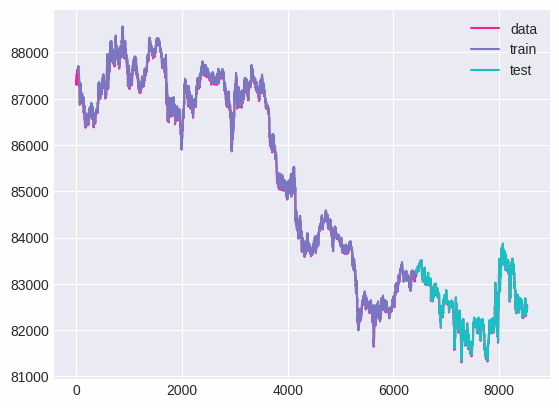

In [ ]:
plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm),color = 'C2', label = 'data')
plt.plot(trainPredictPlot,color = 'C0', label = 'train')
plt.plot(testPredictPlot,color = 'C3', label = 'test')
plt.legend()
plt.show()

Метрики:

In [ ]:
rmse_train= math.sqrt(mean_squared_error(original_ytrain,train_predict))
mae_train=mean_absolute_error(original_ytrain,train_predict)
mape_train=mean_absolute_percentage_error(original_ytrain,train_predict)
rmse_test=math.sqrt(mean_squared_error(original_ytest,test_predict))
mae_test=mean_absolute_error(original_ytest,test_predict)
mape_test=mean_absolute_percentage_error(original_ytest,test_predict)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)


+---------+-----------------------+------------------------+
| RESULTS |         TRAIN         |          TEST          |
+---------+-----------------------+------------------------+
|   rmse  |   48.44725786051011   |   53.39798406957259    |
|   mae   |   36.772769995680854  |   37.266613641769744   |
|   mape  | 0.0004278457914157889 | 0.00045169756408238874 |
+---------+-----------------------+------------------------+


График функций потерь:

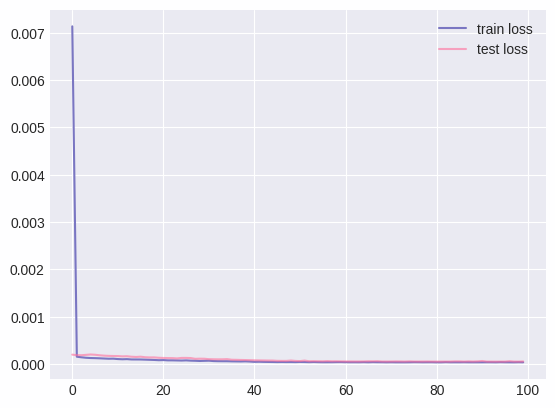

In [ ]:
plt.plot(result.history['loss'],label = 'train loss')
plt.plot(result.history['val_loss'],label = 'test loss')
plt.legend()
plt.show()

-----
сигмоида везде одна и та же:

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30

Подготавливаем данные: скачиваем, нормализуем, формируем выборки

In [ ]:
dataset = get_historical_close_data(companies,step)
scaler=MinMaxScaler(feature_range=(0,1))
dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))
train_dataset, test_dataset = split_train_test(dataset_norm)
train_X, train_y = create_dataset(train_dataset, lookback)
test_X, test_y = create_dataset(test_dataset,lookback)


train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)


LSTM с параметрической сигмоидой.

In [ ]:

class ParametricLSTMCell_sigmoid(LSTMCell):
    def build(self, input_shape):
        super().build(input_shape)
        # Добавляем параметры активации (α и β для сигмоиды)
        self.alpha = self.add_weight(
            name='alpha',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta = self.add_weight(
            name='beta',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )

    def param_sigmoid(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha * (x - self.beta)))

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # предыдущий скрытый
        c_tm1 = states[1]  # предыдущий cell state

        z = K.dot(inputs, self.kernel)
        z += K.dot(h_tm1, self.recurrent_kernel)
        if self.use_bias:
            z = K.bias_add(z, self.bias)

        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

        # Используем нашу сигмоиду
        i = self.param_sigmoid(z0)     # input gate
        f = self.param_sigmoid(z1)     # forget gate
        c = f * c_tm1 + i * K.tanh(z2) # cell state
        o = self.param_sigmoid(z3)     # output gate

        h = o * K.tanh(c)
        return h, [h, c]


Запускаем обучение LSTM с функцией потерь MSE и алгоритмом оптимизации ADAM

In [ ]:
model = Sequential()
model.add(Input(shape=(lookback, 1)))
model.add(RNN(ParametricLSTMCell_sigmoid(unit)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
start_time = time.time()
result=model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=False)
end_time = time.time()
train_timing=(end_time-start_time)

In [ ]:
print(f"time = {train_timing}")

time = 420.6864664554596


Делаем прогноз на тренировочной и тестовой выборке

In [ ]:
train_predict=model.predict(train_X)
start_time = time.time()
test_predict=model.predict(test_X)
end_time = time.time()
test_timing=(end_time-start_time)
#train_predict.shape, test_predict.shape
print(f"time = {test_timing}")

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
time = 0.6838870048522949


Возвращаем данные в исходные единицы измерения

In [ ]:

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1))
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

График с оригинальными данными и прогнозами:

In [ ]:
trainPredictPlot = np.empty_like(dataset_norm)
trainPredictPlot[:, ] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, ] = train_predict[:,0].reshape(-1,1)
testPredictPlot = np.empty_like(dataset_norm)
testPredictPlot[:,] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ] = test_predict[:,0].reshape(-1,1)



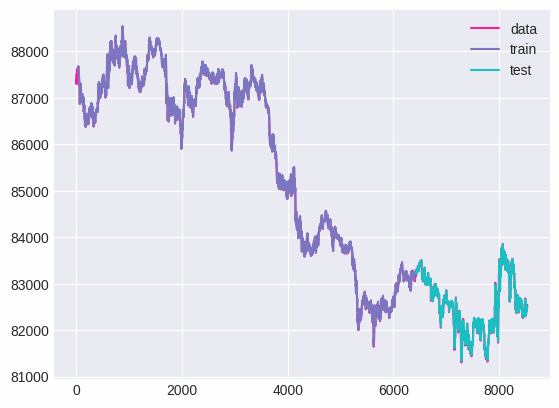

In [ ]:
plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm),color = 'C2', label = 'data')
plt.plot(trainPredictPlot,color = 'C0', label = 'train')
plt.plot(testPredictPlot,color = 'C3', label = 'test')
plt.legend()
plt.show()

Метрики:

In [ ]:
rmse_train= math.sqrt(mean_squared_error(original_ytrain,train_predict))
mae_train=mean_absolute_error(original_ytrain,train_predict)
mape_train=mean_absolute_percentage_error(original_ytrain,train_predict)
rmse_test=math.sqrt(mean_squared_error(original_ytest,test_predict))
mae_test=mean_absolute_error(original_ytest,test_predict)
mape_test=mean_absolute_percentage_error(original_ytest,test_predict)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)


+---------+------------------------+------------------------+
| RESULTS |         TRAIN          |          TEST          |
+---------+------------------------+------------------------+
|   rmse  |   42.12102944805435    |   52.52754425660891    |
|   mae   |   29.619137250667503   |   35.379419154376784   |
|   mape  | 0.00034531229204645794 | 0.00042884581026475434 |
+---------+------------------------+------------------------+


График функций потерь:

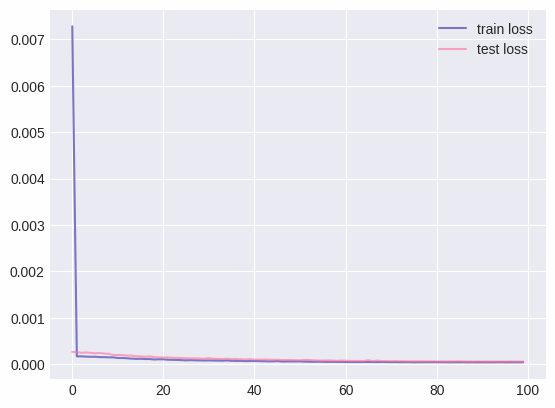

In [ ]:
plt.plot(result.history['loss'],label = 'train loss')
plt.plot(result.history['val_loss'],label = 'test loss')
plt.legend()
plt.show()

-----

теперь вместо $tanh$ -- парметрическая сигмоида

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30

Подготавливаем данные: скачиваем, нормализуем, формируем выборки

In [ ]:
dataset = get_historical_close_data(companies,step)
scaler=MinMaxScaler(feature_range=(0,1))
dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))
train_dataset, test_dataset = split_train_test(dataset_norm)
train_X, train_y = create_dataset(train_dataset, lookback)
test_X, test_y = create_dataset(test_dataset,lookback)


train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)


In [ ]:
class ParametricLSTMCell_mega(LSTMCell):
    def build(self, input_shape):
        super().build(input_shape)
        # Добавляем параметры активации (α и β для сигмоиды)
        self.alpha = self.add_weight(
            name='alpha',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta = self.add_weight(
            name='beta',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )
        self.alpha2 = self.add_weight(
            name='alpha2',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta2 = self.add_weight(
            name='beta2',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )
        self.alpha3 = self.add_weight(
            name='alpha3',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta3 = self.add_weight(
            name='beta3',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )
        self.alpha4 = self.add_weight(
            name='alpha4',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta4 = self.add_weight(
            name='beta4',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )
        self.alpha5 = self.add_weight(
            name='alpha5',
            shape=(1,),
            initializer=Constant(1.0),
            trainable=True
        )
        self.beta5 = self.add_weight(
            name='beta5',
            shape=(1,),
            initializer=Constant(0.0),
            trainable=True
        )

    def param_sigmoid(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha * (x - self.beta)))

    def param_sigmoid2(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha2 * (x - self.beta2)))

    def param_sigmoid3(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha3 * (x - self.beta3)))

    def param_sigmoid4(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha4 * (x - self.beta4)))

    def param_sigmoid5(self, x):
        return 1.0 / (1.0 + K.exp(-self.alpha5 * (x - self.beta5)))

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # предыдущий скрытый
        c_tm1 = states[1]  # предыдущий cell state

        z = K.dot(inputs, self.kernel)
        z += K.dot(h_tm1, self.recurrent_kernel)
        if self.use_bias:
            z = K.bias_add(z, self.bias)

        z0, z1, z2, z3 = tf.split(z, num_or_size_splits=4, axis=1)

        # Используем нашу сигмоиду
        i = self.param_sigmoid(z0)     # input gate
        f = self.param_sigmoid2(z1)     # forget gate
        c = f * c_tm1 + i *self.param_sigmoid4(z2) # cell state
        o = self.param_sigmoid3(z3)     # output gate

        h = o * self.param_sigmoid5(c)
        return h, [h, c]

Запускаем обучение LSTM с функцией потерь MSE и алгоритмом оптимизации ADAM

In [ ]:
model = Sequential()
model.add(Input(shape=(lookback, 1)))
model.add(RNN(ParametricLSTMCell_mega(unit)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
start_time = time.time()
result=model.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=False)
end_time = time.time()
train_timing=(end_time-start_time)

In [ ]:
print(f"time = {train_timing}")

time = 518.6399273872375


Делаем прогноз на тренировочной и тестовой выборке

In [ ]:
train_predict=model.predict(train_X)
start_time = time.time()
test_predict=model.predict(test_X)
end_time = time.time()
test_timing=(end_time-start_time)
#train_predict.shape, test_predict.shape
print(f"time = {test_timing}")

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
time = 0.682628870010376


Возвращаем данные в исходные единицы измерения

In [ ]:

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1))
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

График с оригинальными данными и прогнозами:

In [ ]:
trainPredictPlot = np.empty_like(dataset_norm)
trainPredictPlot[:, ] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, ] = train_predict[:,0].reshape(-1,1)
testPredictPlot = np.empty_like(dataset_norm)
testPredictPlot[:,] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(dataset['Close'])-1, ] = test_predict[:,0].reshape(-1,1)



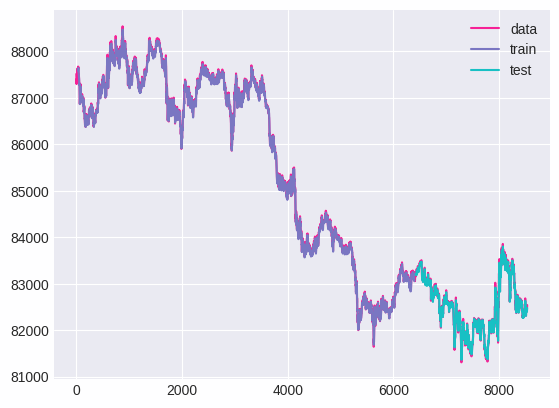

In [ ]:
plt.plot(de_normalization(dataset['Close'].values.reshape(-1,1),dataset_norm),color = 'C2', label = 'data')
plt.plot(trainPredictPlot,color = 'C0', label = 'train')
plt.plot(testPredictPlot,color = 'C3', label = 'test')
plt.legend()
plt.show()

Метрики:

In [ ]:
rmse_train= math.sqrt(mean_squared_error(original_ytrain,train_predict))
mae_train=mean_absolute_error(original_ytrain,train_predict)
mape_train=mean_absolute_percentage_error(original_ytrain,train_predict)
rmse_test=math.sqrt(mean_squared_error(original_ytest,test_predict))
mae_test=mean_absolute_error(original_ytest,test_predict)
mape_test=mean_absolute_percentage_error(original_ytest,test_predict)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)


+---------+-----------------------+------------------------+
| RESULTS |         TRAIN         |          TEST          |
+---------+-----------------------+------------------------+
|   rmse  |   48.90669207583922   |    55.9539102702728    |
|   mae   |   36.87010046921627   |   39.06679650333016    |
|   mape  | 0.0004298586987547135 | 0.00047322107769584814 |
+---------+-----------------------+------------------------+


График функций потерь:

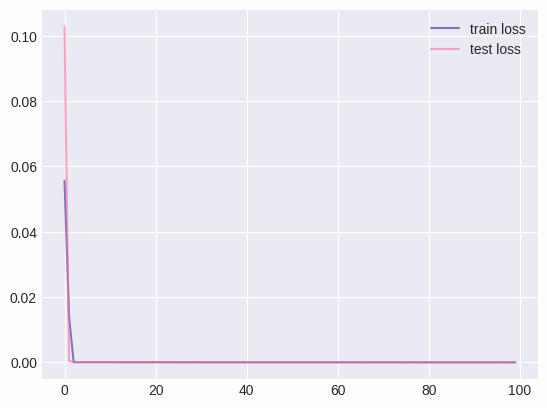

In [ ]:
plt.plot(result.history['loss'],label = 'train loss')
plt.plot(result.history['val_loss'],label = 'test loss')
plt.legend()
plt.show()

------
-----

### **Fuzzy LSTM**

In [ ]:
step= '1m'
unit = 16
companies = 'BTC-USD'
lookback=30
window = 10

Подготавливаем данные: скачиваем, нормализуем, формируем выборки

In [ ]:
# 3. Создание датасета с признаками
def create_dataset_multifeature(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i:(i + lookback), :]
        dataX.append(a)
        dataY.append(dataset[i + lookback, :])  # теперь y — вектор из 2 значений
    return np.array(dataX), np.array(dataY)

In [ ]:
dataset = get_historical_close_data(companies,step)
scaler=MinMaxScaler(feature_range=(0,1))
dataset_norm=scaler.fit_transform(np.array(dataset['Close'].values).reshape(-1,1))

In [ ]:
# === Фаззи-признак ===
fuzzy_feature = fuzzify(dataset_norm, window)

# Добавим фаззи-признак в нормализованный датасет
dataset_fuzzy = np.hstack((dataset_norm, fuzzy_feature))  # shape = (n_samples, 2)

train_dataset_fuzzy, test_dataset_fuzzy = split_train_test(dataset_fuzzy)

train_X, train_y = create_dataset_multifeature(train_dataset_fuzzy, lookback)
test_X, test_y = create_dataset_multifeature(test_dataset_fuzzy, lookback)


train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 2)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 2)


In [ ]:
model = Sequential()
model.add(Input(shape=(lookback, 2)))
model.add(RNN(ParametricLSTMCell_sigmoid(unit)))
model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')

In [ ]:
# === Обучение ===
start_time = time.time()
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=False)
train_time = time.time() - start_time
print(f"time = {train_time}")

time = 452.3134620189667


In [ ]:
# === Предсказания ===
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


+---------+-----------------------+------------------------+
| RESULTS |         TRAIN         |          TEST          |
+---------+-----------------------+------------------------+
|   rmse  |   31.610449757501865  |   36.76547886104042    |
|   mae   |   16.687353983430185  |   18.00103324215033    |
|   mape  | 0.0001943214945680931 | 0.00021781413024961384 |
+---------+-----------------------+------------------------+


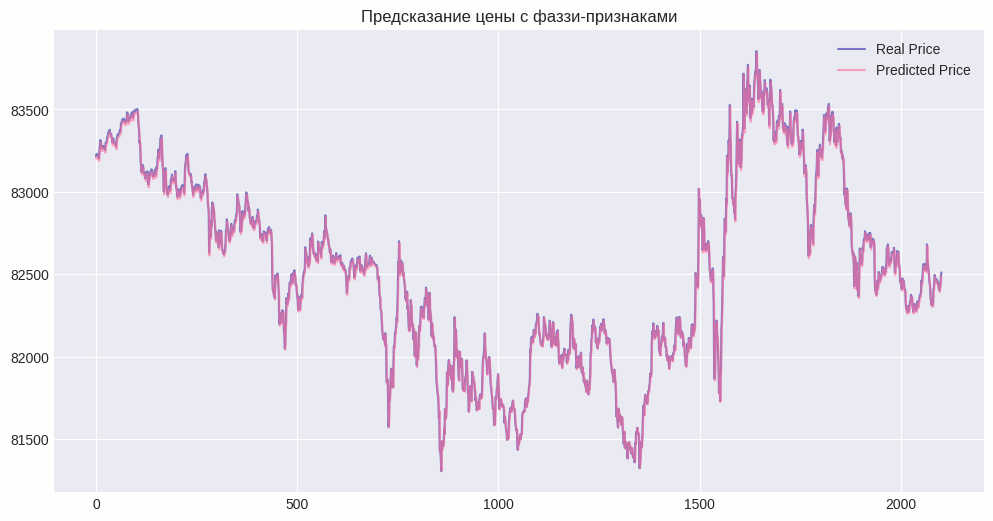

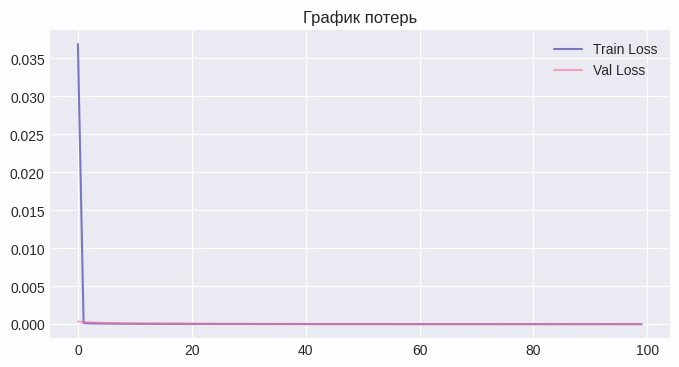

In [ ]:
#Де-нормализация предсказаний и реальных значений
train_pred_denorm = scaler.inverse_transform(train_predict.T.reshape(-1, 1))
test_pred_denorm = scaler.inverse_transform(test_predict.T.reshape(-1, 1))
y_train_denorm = scaler.inverse_transform(train_y.T.reshape(-1, 1))
y_test_denorm = scaler.inverse_transform(test_y.T.reshape(-1, 1))


# === Метрики ===
rmse_train= math.sqrt(mean_squared_error(y_train_denorm, train_pred_denorm))
mae_train=mean_absolute_error(y_train_denorm, train_pred_denorm)
mape_train=mean_absolute_percentage_error(y_train_denorm, train_pred_denorm)
rmse_test=math.sqrt(mean_squared_error(y_test_denorm, test_pred_denorm))
mae_test=mean_absolute_error(y_test_denorm, test_pred_denorm)
mape_test=mean_absolute_percentage_error(y_test_denorm, test_pred_denorm)

my_table = PrettyTable()
my_table.field_names = [f"RESULTS", "TRAIN", "TEST"]
my_table.add_row(["rmse", rmse_train, rmse_test])
my_table.add_row(["mae", mae_train, mae_test])
my_table.add_row(["mape",mape_train, mape_test])

print(my_table)

# === Визуализация ===
l = np.shape(y_test_denorm)[0]
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm[:int(l/2),0], label='Real Price')
plt.plot(test_pred_denorm[:int(l/2),0], label='Predicted Price')
plt.title("Предсказание цены с фаззи-признаками")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("График потерь")
plt.legend()
plt.show()

